## Twitter Analysis

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import json

from sklearn.metrics import classification_report, confusion_matrix

### Copy tar gz file from S3
#### Update the S3 path to point to the file in your bucket

In [ ]:
!aws s3 cp s3://<replace path>/output.tar.gz .    

In [3]:
# Extract the tar file content
import tarfile
tar = tarfile.open("output.tar.gz")
tar.extractall()
tar.close()

In [4]:
ls

aml_training_dataset.csv          twitter_data_preparation.ipynb
output.tar.gz                     twitter_test_with_label.csv
predictions.jsonl                 twitter_test_without_label.csv
twitter_analysis.ipynb            twitter_train.csv
twitter_analysis_sentiment.ipynb


In [5]:
test_file = 'twitter_test_with_label.csv'
predicted_file = 'predictions.jsonl'

In [6]:
# Specify the column names as the file does not have column header
df = pd.read_csv(test_file,names=['trainingLabel','text'])

In [7]:
df.head()

,trainingLabel,text
0,0,@awscloud VBar has Guiness ... No need to craw...
1,0,Is #cloud giant #Google ready for the cloud ba...
2,0,Coming from Amazon Web Services: Better #Docke...
3,0,"SAP Business One, version for #SAP HANA, is no..."
4,1,@awscloud Shall you please check my concern to...


In [8]:
predicted_class = []
predicted_prob = []

with open(predicted_file,'r') as f:
    l = f.readline()
    while (l):
        j = json.loads(l)
        if j['Classes'][0]['Name'] == '0':            
            predicted_class.append(0)
            # Add positive class probability
            predicted_prob.append(j['Classes'][1]['Score'])
        else:
            predicted_class.append(1)
            # Add positive class probability
            predicted_prob.append(j['Classes'][0]['Score'])
        
        l = f.readline()

In [9]:
print(predicted_prob[:5],predicted_prob[-5:])
print(predicted_class[:5],predicted_class[-5:])

[0.0462, 0.026, 0.0003, 0.0114, 0.5852] [0.9474, 0.0169, 0.0248, 0.0, 0.0105]
[0, 0, 0, 0, 1] [1, 0, 0, 0, 0]


In [10]:
df['predicted_class'] = predicted_class
df['predicted_prob'] = predicted_prob

In [11]:
df.head()

,trainingLabel,text,predicted_class,predicted_prob
0,0,@awscloud VBar has Guiness ... No need to craw...,0,0.0462
1,0,Is #cloud giant #Google ready for the cloud ba...,0,0.0260
2,0,Coming from Amazon Web Services: Better #Docke...,0,0.0003
3,0,"SAP Business One, version for #SAP HANA, is no...",0,0.0114
4,1,@awscloud Shall you please check my concern to...,1,0.5852


In [12]:
df.tail()

,trainingLabel,text,predicted_class,predicted_prob
995,1,"@awscloud is down, the internet is down. p.s....",1,0.9474
996,0,Amazon Web Services @awscloud to use wind farm...,0,0.0169
997,0,"With #ASIO new powers, I guess every single se...",0,0.0248
998,0,@awscloud http://t.co/ofkH3dsvDR good one,0,0.0000
999,0,@wc_1975 @awscloud @AccentureCloud I loved the...,0,0.0105


## Binary Classifier Metrics

In [13]:
# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html
# Explicitly stating labels. Pass=1, Fail=0
def true_positive(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 0]

def true_negative(y_true, y_pred): 
    return confusion_matrix(y_true,y_pred,labels=[1,0])[1, 1]

def false_positive(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[1, 0]

def false_negative(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 1]

In [14]:
# Compute Binary Classifier Metrics
# Returns a dictionary {"MetricName":Value,...}

def binary_classifier_metrics(y_true, y_pred):
    metrics = {}

    # References: 
    #  https://docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html
    #  https://en.wikipedia.org/wiki/Confusion_matrix
    
    # Definition:
    # true positive = tp = how many samples were correctly classified as positive (count)
    # true negative = tn = how many samples were correctly classified as negative (count)
    # false positive = fp = how many negative samples were mis-classified as positive (count)
    # false_negative = fn = how many positive samples were mis-classified as negative (count)
    
    # positive = number of positive samples (count)
    #          = true positive + false negative
    # negative = number of negative samples (count)
    #          = true negative + false positive
    
    tp = true_positive(y_true, y_pred)
    tn = true_negative(y_true, y_pred)
    fp = false_positive(y_true, y_pred)
    fn = false_negative(y_true, y_pred)
    
    positive = tp + fn
    negative = tn + fp
    
    metrics['TruePositive'] = tp
    metrics['TrueNegative'] = tn
    metrics['FalsePositive'] = fp
    metrics['FalseNegative'] = fn
    
    metrics['Positive'] = positive
    metrics['Negative'] = negative
    
    # True Positive Rate (TPR, Recall) = true positive/positive
    # How many positives were correctly classified? (fraction)
    # Recall value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        recall = 0
    else:
        recall = tp/positive
        
    metrics['Recall'] = recall
    
    # True Negative Rate = True Negative/negative
    # How many negatives were correctly classified? (fraction)
    # True Negative Rate value closer to 1 is better. closer to 0 is worse
    if tn == 0:
        tnr = 0
    else:
        tnr = tn/(negative)
    metrics['TrueNegativeRate'] = tnr
    
    # Precision = True Positive/(True Positive + False Positive)
    # How many positives classified by the algorithm are really positives? (fraction)
    # Precision value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        precision = 0
    else:
        precision = tp/(tp + fp)
    metrics['Precision'] = precision
    
    # Accuracy = (True Positive + True Negative)/(total positive + total negative)
    # How many positives and negatives were correctly classified? (fraction)
    # Accuracy value closer to 1 is better. closer to 0 is worse
    accuracy = (tp + tn)/(positive + negative)
    metrics['Accuracy'] = accuracy
    
    # False Positive Rate (FPR, False Alarm) = False Positive/(total negative)
    # How many negatives were mis-classified as positives (fraction)
    # False Positive Rate value closer to 0 is better. closer to 1 is worse
    if fp == 0:
        fpr = 0
    else:
        fpr = fp/(negative)
    metrics['FalsePositiveRate'] = fpr
    
    # False Negative Rate (FNR, Misses) = False Negative/(total Positive)
    # How many positives were mis-classified as negative (fraction)
    # False Negative Rate value closer to 0 is better. closer to 1 is worse
    fnr = fn/(positive)
    metrics['FalseNegativeRate'] = fnr
    
    # F1 Score = harmonic mean of Precision and Recall
    # F1 Score closer to 1 is better. Closer to 0 is worse.
    if precision == 0 or recall == 0:
        f1 = 0
    else:        
        f1 = 2*precision*recall/(precision+recall)

    metrics['F1'] = f1
    
    return metrics

In [15]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [16]:
df.columns

Index(['trainingLabel', 'text', 'predicted_class', 'predicted_prob'], dtype='object')

In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['trainingLabel'], df['predicted_class'],labels=[1,0])

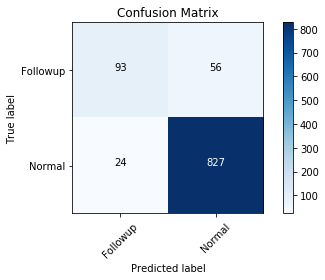

In [18]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Followup','Normal'],
                      title='Confusion Matrix')

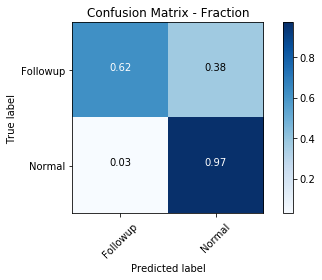

In [19]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Followup','Normal'],
                      title='Confusion Matrix - Fraction', normalize=True)

In [20]:
metrics = [binary_classifier_metrics(df['trainingLabel'], df['predicted_class'])]
df_metrics=pd.DataFrame.from_dict(metrics)
df_metrics.index = ['Model']

In [21]:
df_metrics

,Accuracy,F1,FalseNegative,FalseNegativeRate,FalsePositive,FalsePositiveRate,Negative,Positive,Precision,Recall,TrueNegative,TrueNegativeRate,TruePositive
Model,0.92,0.699248,56,0.375839,24,0.028202,851,149,0.794872,0.624161,827,0.971798,93


In [22]:
print('Counts')
print(df_metrics[['TruePositive',
                  'FalseNegative',
                  'FalsePositive',
                  'TrueNegative',]].round(2))
print()
print('Fractions')
print(df_metrics[['Recall',
                  'FalseNegativeRate',
                  'FalsePositiveRate',
                  'TrueNegativeRate',]].round(2))
print()

print(df_metrics[['Precision',
                  'Accuracy',
                  'F1']].round(2))

Counts
       TruePositive  FalseNegative  FalsePositive  TrueNegative
Model            93             56             24           827

Fractions
       Recall  FalseNegativeRate  FalsePositiveRate  TrueNegativeRate
Model    0.62               0.38               0.03              0.97

       Precision  Accuracy   F1
Model       0.79      0.92  0.7


In [23]:
print(classification_report(
    df['trainingLabel'],
    df['predicted_class'],
    labels=[1,0],
    target_names=['Followup','Normal']))

              precision    recall  f1-score   support

    Followup       0.79      0.62      0.70       149
      Normal       0.94      0.97      0.95       851

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.87      0.80      0.83      1000
weighted avg       0.92      0.92      0.92      1000



In [24]:
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(df['trainingLabel'],df['predicted_prob'])
print('AUC Score: {0:.3f}'.format(roc_score))

AUC Score: 0.939


In [25]:
df = df.sort_values('trainingLabel')
df = df.reset_index(drop=True)

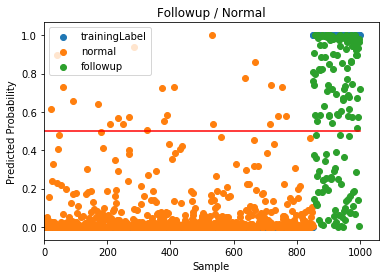

In [26]:
normal = df[df['trainingLabel']==0]
followup = df[df['trainingLabel']==1]
plt.figure()
plt.scatter(df.index,df['trainingLabel'])
plt.scatter(normal.index,normal['predicted_prob'],label='normal')
plt.scatter(followup.index,followup['predicted_prob'],label='followup')
plt.plot([df.index.min(),df.index.max()],[0.5,0.5],color='r')
plt.xlim(left=0)
plt.xlabel('Sample')
plt.ylabel('Predicted Probability')
plt.title('Followup / Normal')
plt.legend(loc=0)
plt.show()

#### Finding the optimal cutoff

```txt
$30 * FN(C) + $0 * TN(C) + $10 * FP(C) + $10 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

Ref: https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/

In [27]:
pd.crosstab(index=df['trainingLabel'],columns=np.where(df['predicted_prob'] > .5, 1, 0))

col_0,0,1
trainingLabel,,
0,827,24
1,56,93


In [28]:
cutoffs = np.arange(0.1, .9, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 10], [30, 10]]) * 
                               pd.crosstab(index=df['trainingLabel'],columns=np.where(df['predicted_prob'] > c, 1, 0)))))

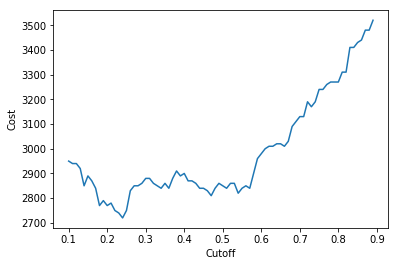

Cost is minimized near a cutoff of: 0.23999999999999994 for a cost of: 2720


In [29]:
costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.ylabel('Cost')
plt.xlabel('Cutoff')
plt.show()

print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

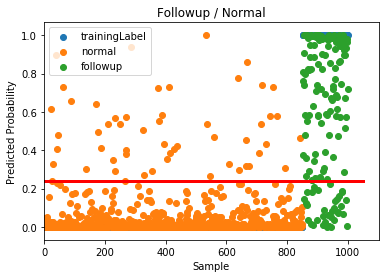

In [30]:
normal = df[df['trainingLabel']==0]
followup = df[df['trainingLabel']==1]
plt.figure()
plt.scatter(df.index,df['trainingLabel'])
plt.scatter(normal.index,normal['predicted_prob'],label='normal')
plt.scatter(followup.index,followup['predicted_prob'],label='followup')
plt.plot([df.index.min(),df.index.max()+50],[cutoffs[np.argmin(costs)],cutoffs[np.argmin(costs)]],color='r',linewidth=3)
plt.xlim(left=0)
plt.xlabel('Sample')
plt.ylabel('Predicted Probability')
plt.title('Followup / Normal')
plt.legend(loc=0)
plt.show()

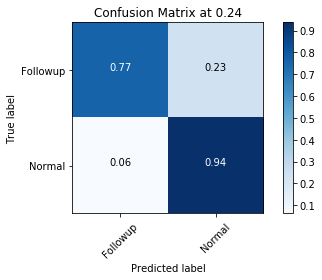

In [33]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['trainingLabel'], np.where(df['predicted_prob'] > cutoffs[np.argmin(costs)], 1, 0),labels=[1,0])

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Followup','Normal'],
                      title='Confusion Matrix at {0:0.2f}'.format(cutoffs[np.argmin(costs)]), normalize=True)

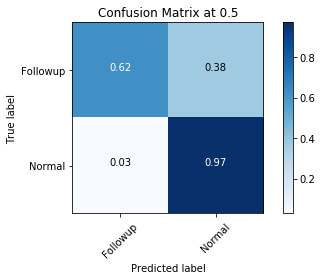

In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['trainingLabel'], np.where(df['predicted_prob'] > .5, 1, 0),labels=[1,0])

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Followup','Normal'],
                      title='Confusion Matrix at 0.5', normalize=True)